In [1]:
using Pkg
Pkg.activate(".")
using LinearNoiseApproximation # need to import package from Julia to have LNA() function work
using DifferentialEquations
using Catalyst
using Reexport
using ModelingToolkit
using DiffEqBase
using JumpProcesses
using Plots
include("utils.jl") # need to import this utility file locally for LNA helper functions to work

using DifferentialEquations.EnsembleAnalysis
using Symbolics
using LinearAlgebra
using RowEchelon
using Statistics
using NonlinearSolve
using NLsolve
using SymPy
using SymbolicUtils

  Activating project at `~/Documents/EMRE Julia Package`


In [2]:
## go through each reaction and adjust parameters to make units 1/t, i.e. multiply 0 --> X reactions by volume and divide biomolecular ones by volume, check if biomolecular reaction is same-species and if so multiply by 2
function adjustParams(rn::ReactionSystem, params, volume)

    systemParams = rn.ps
    systemReactions = rn.rxs
    
    adjustedTF = falses(length(systemParams))

    adjustedParams = copy(Float64.(params))

    for reaction in systemReactions
        if length(reaction.substrates) == 0 ## check if it's a zero order reaction
            paramIndex = findfirst(x->isequal(x,reaction.rate), systemParams) ## if it is, find what number parameter it is
            if !adjustedTF[paramIndex] ## if it hasn't already been adjusted
                adjustedParams[paramIndex] = adjustedParams[paramIndex]*volume ## multiply by volume
                adjustedTF[paramIndex] = true ## mark that it was adjusted
            end
        end
        if length(reaction.substrates) == 2 ## check if it's a biomolecular reaction
            paramIndex = findfirst(x->isequal(x,reaction.rate), systemParams) ## if it is, find what number parameter it is
            if !adjustedTF[paramIndex] ## if it hasn't already been adjusted
                adjustedParams[paramIndex] = adjustedParams[paramIndex]/volume ## divide by volume
                adjustedTF[paramIndex] = true
            end
        end
        if (length(reaction.substrates) == 1) && (reaction.substoich[1] == 2) ## check if it's a biomolecular reaction with same-species
            paramIndex = findfirst(x->isequal(x,reaction.rate), systemParams) ## if it is, find what number parameter it is
            if !adjustedTF[paramIndex] ## if it hasn't already been adjusted
                adjustedParams[paramIndex] = adjustedParams[paramIndex] * (2/volume) ## if it is, multiplay rate by 2/volume
                adjustedTF[paramIndex] = true ## mark that it's been adjusted
            end
        end
    end

    return adjustedParams
end;


In [3]:
## will set up the paramaters to pass to the LNA functions and the SSA functions

function setParams(rn::ReactionSystem, params, volume)

    LNAparams = params;
    SSAparams = adjustParams(rn, params, volume) ## needs to know which rates are involved in biomolecular reactions as well as which ones need to be adjusted for units

    return LNAparams, SSAparams
end;

In [4]:
function runSSA(rn::ReactionSystem, ics, params, volume, tEnd, numSteps, numTrajs)

    tSpan = (0.0, tEnd); ## make time span
    timePoints = LinRange(0, tEnd, numSteps); ## set up time points to calculate SSA means at
    
    ## set up and run ensemble problem
    jumpsys = convert(JumpSystem, rn);
    dprob = DiscreteProblem(jumpsys, ics, tSpan, params);
    jprob = JumpProblem(jumpsys, dprob, Direct(), save_positions=(false, false));
    eprob = EnsembleProblem(jprob) 

    jsol = solve(eprob, SSAStepper(), trajectories = numTrajs, saveat = tEnd/(numSteps-1));

    means = timepoint_mean(jsol, timePoints)/volume; ## caclulate mean concentrations through time

    return timePoints, means
end;

In [69]:
function runLNA(rn::ReactionSystem, ics, params, volume, tEnd, numSteps)

    tSpan = (0.0, tEnd); ## set up time span

    ## set up and solve LNA problem from LinearNoiseApproximation.jl package
    lna = LNASystem(rn)
    lnaDEs = lna.odesys; ## only want ODEs to turn into a SS problem

    initGuesses = zeros(2*length(rn.species)+binomial(length(rn.species),2));
    initGuesses[1:length(rn.species)] = ics;
    ssProb = SteadyStateProblem(lnaDEs, initGuesses/volume, [rn.ps[i] => params[i] for i in 1:length(rn.ps)]);

    sol = solve(ssProb, DynamicSS(tspan=1000))

    ## get indices of means and variances for each species in system
    meanIdxs, varIdxs = find_states_cov_number(collect(1:length(rn.species)), lna);

    return meanIdxs, varIdxs, sol

end;

In [6]:
function buildDeltaVect(rn::ReactionSystem, params, meanIdxs, varIdxs, LNAsol)

    deltaVec = zeros(length(rn.species))
        
    for reaction in rn.rxs
            
        if length(reaction.substrates) == 2 ## if a biomolecular reaction of different species

            species1idx = findfirst(x->isequal(x,reaction.substrates[1]), rn.species) ## find first species
            species2idx = findfirst(x->isequal(x,reaction.substrates[2]), rn.species) ## find second species

            covIdx = varIdxs[min(species1idx, species2idx)] + (max(species1idx, species2idx) - min(species1idx, species2idx)) ## find index of covariance, e.g. species 5 & 3 gives varIdxs[3] (which is variance of s3) + 2
            cov = LNAsol[covIdx] ## get covariance in SS (can change later to be in time)

            rateParamIdx = findfirst(x->isequal(x, reaction.rate), rn.ps) ## find what parameter is the rate 
            rate = params[rateParamIdx] ## get numerical rate from parameters
            
            adjustment = rate*cov ## k*<e_i,e_j>

            ## subtract the adjustment term from the two reactants
            deltaVec[species1idx] -= adjustment
            deltaVec[species2idx] -= adjustment
            
            for species in reaction.products ## for each product made in reaction

                prodIdx = findfirst(x->isequal(x,species),reaction.products) ## see what index it is in product list
                numProduced = reaction.prodstoich[prodIdx] ## see how many are produced by reaction

                speciesIdx = findfirst(x->isequal(x, species), rn.species) ## find index in the system species
                deltaVec[speciesIdx] += numProduced * adjustment ## add adjustment term for each one produced (??)
            end
        end

        if length(reaction.substrates) == 1 && (reaction.substoich[1] == 2) ## if it's a biomolecular reaction with the same species
                
            speciesIdx = findfirst(x->isequal(x, reaction.substrates[1]), rn.species) ## find what species it is

            ## find indices of its mean and variance
            meanIdx = meanIdxs[speciesIdx]
            varIdx = varIdxs[speciesIdx] 
            mean = LNAsol[meanIdx] ## SS mean (can change later to be in time)
            var = LNAsol[varIdx] ## SS var (can change later to be in time)

            rateParamIdx = findfirst(x->isequal(x, reaction.rate), rn.ps) ## find what parameter is the rate 
            rate = params[rateParamIdx] ## get numerical rate from parameters

            adjustment = rate * (var - mean) ## k * [<e_i^2> - phi_i]

            deltaVec[speciesIdx] -= 2 * adjustment ## subtract 2 * the adjustment from the reactants

            for species in reaction.products

                prodIdx = findfirst(x->isequal(x,species),reaction.products) ## see what index it is in product list
                numProduced = reaction.prodstoich[prodIdx] ## see how many are produced by reaction

                speciesIdx = findfirst(x->isequal(x, species), rn.species) ## find index in the system species
                deltaVec[speciesIdx] += numProduced * adjustment ## add adjustment term for each one produced (??)
            end
        end
    end

    return deltaVec
end;

In [7]:
function getInvJac(rn::ReactionSystem, params, meanIdxs, LNAsol, reducedSpecies = nothing, reducedSystem = nothing)

    if reducedSpecies != nothing && reducedSystem != nothing ## if there are conservation laws
        
        jacMat = calculate_jacobian(reducedSystem) ## find the Jacobian of the reduced system
        subDict = Dict([])

        for species in reducedSpecies
            speciesIdx = findfirst(x->isequal(x, species), rn.species) ## get index
            subDict[species] = LNAsol[meanIdxs[speciesIdx]] ## if species shows up in Jacobian, substitute its steady state value)
        end
        for param in rn.ps ## for each parameter in the system
            paramIdx = findfirst(x->isequal(x,param), rn.ps) ## get index
            subDict[param] = params[paramIdx] ## if parameter shows up in Jacobian, substitute the numerically value supplied
        end
        
        jacMatNumerical = substitute(jacMat, subDict) ## sub in numerical values into Jacobian
        jacMatInv = inv(jacMatNumerical) ## get inverse of Jacobian

    else
        sys = convert(ODESystem, rn, combinatoric_ratelaws=false, remove_conserved=true); ## convert reactioin system to ODE system
        jacMat = calculate_jacobian(sys); ## get the Jacobian
        
        subDict = Dict([]) ## initialize dictionary for substituting variables and steady states
        for species in rn.species ## for each species in the system
            speciesIdx = findfirst(x->isequal(x, species), rn.species) ## get index
            subDict[species] = LNAsol[meanIdxs[speciesIdx]] ## if species shows up in Jacobian, substitute its steady state value
        end
        for param in rn.ps ## for each parameter in the system
            paramIdx = findfirst(x->isequal(x,param), rn.ps) ## get index
            subDict[param] = params[paramIdx] ## if parameter shows up in Jacobian, substitute the numerically value supplied
        end
        jacMatNumerical = substitute(jacMat, subDict) ## sub in numerical values into Jacobian
        jacMatInv = inv(jacMatNumerical) ## get inverse of Jacobian
    end
    
    return jacMatInv
end;

In [8]:
function getRealizedVector(rn::ReactionSystem, ics, params, meanIdxs, varIdxs, LNAsol, volume)

    SS = zeros(length(rn.species)) ## initialize vector for deterministic steady states
    for species in rn.species ## for each species
        speciesIdx = findfirst(x->isequal(x, species), rn.species) ## find index in system
        SS[speciesIdx] = LNAsol[meanIdxs[speciesIdx]] ## record steady state value
    end

    deltaVec = buildDeltaVect(rn, params, meanIdxs, varIdxs, LNAsol) ## get delta vector with adjustments

    conservationEqs = conservedequations(rn) ## get conservation laws

    if length(conservationEqs) > 0 ## if there are conservation laws
        
        conservationConstants = conservationlaw_constants(rn)
        
        icDict = Dict([rn.species[i]=>ics[i]/volume for i in 1:length(rn.species)])
        conservationConstants = substitute(conservationConstants, icDict)
        
        constDict = Dict([conservationConstants[i].lhs => conservationConstants[i].rhs for i in 1:length(conservationEqs)])
        conservationEqs = substitute(conservationEqs, constDict)
        
        reducedSpecies, reducedSystem = buildNewDESystem(rn, conservationEqs) ## get the reduced system
        invJac = getInvJac(rn, params, meanIdxs, LNAsol, reducedSpecies, reducedSystem);

        deltaVecReduced = [deltaVec[findfirst(x->isequal(x, species), rn.species)] for species in reducedSpecies] ## get the delta vector entries for only the remaining species
   
        realizedSS = zeros(length(rn.species)) ## initialize vector to hold realized S.S.
        subDict = Dict([])
        i = 1
        for species in reducedSpecies ## for the remaining species in the reduced system
            speciesIdx = findfirst(x->isequal(x, species), rn.species) ## find which species it is in the original system
            realizedSS[speciesIdx] = SS[speciesIdx] - ( (1/volume)*invJac*deltaVecReduced )[i] ## Eq. 26 from 2009 paper
            subDict[species] = realizedSS[speciesIdx] ## record it's realized S.S. to use in conservation laws
            i += 1
        end

        for law in conservationEqs ## for each conservation law
            speciesToCompute = findfirst(x->isequal(x, law.lhs), rn.species) ## check what species it is for
            realizedSS[speciesToCompute] = substitute(law.rhs, subDict) ## find the realized S.S. by subbing independent species' S.S. in
        end

    else ## getting Jacobian and realized vector normally
        invJac = getInvJac(rn, params, meanIdxs, LNAsol) ## get inverse Jacobian
        realizedSS = SS - (1/volume)*invJac*deltaVec ## Eq. 26 from 2009 paper
    end;  
    return SS, realizedSS
end;

In [9]:
function buildNewDESystem(rn::ReactionSystem, conservationLaws)
    
    sys = convert(ODESystem, rn, combinatoric_ratelaws = false) ## convert the ReactionSystem to an ODESystem
    indicesToRemove = [] ## to keep track of which species to remove
    subDict = Dict([]) ## to keep track of conservation laws to sub in for removed species
    for law in conservationLaws ## for each conservation law
        index = findfirst(x->isequal(x, law.lhs), rn.species) ## find what species it is for
        push!(indicesToRemove, index) ## record the species' index
        subDict[rn.species[index]] = law.rhs  ## add the conservation law to the substiution dictionary
    end

    reducedSystem = [] ## to keep track of the ODEs in the new reduced system
    reducedSpecies = [] ## to keep track of the species left in the reduced system
    for i in 1:length(rn.species) ## for each species
        if i in indicesToRemove ## if it is being removed, move on
            continue
        end
        push!(reducedSystem,sys.eqs[i]) ## if it's not being removed, record itss DE
        push!(reducedSpecies, rn.species[i]) ## '' record its variable
    end
    
    @named newSystem = ODESystem([substitute(eq, subDict) for eq in reducedSystem]) ## convert the remaining DEs to an ODESystem
    # reducedSpecies = states(newSystem) ## could simplify using this
    return reducedSpecies, newSystem
end;

In [10]:
function EMRE(rn::ReactionSystem, ics, params, volume, tEnd, numSteps, numTrajs)

   LNAparams, SSAparams = setParams(rn, params, volume)
   
   timePoints, SSAmeans = runSSA(rn, ics, SSAparams, volume, tEnd, numSteps, numTrajs)
   meanIdxs, varIdxs, LNAsol = runLNA(rn, ics, LNAparams, volume, tEnd, numSteps)
   
   SS, realizedSS = getRealizedVector(rn, ics, LNAparams, meanIdxs, varIdxs, LNAsol, volume)
   
   return timePoints, SSAmeans, SS, realizedSS
end;

In [11]:
function createSubSpecies(symbol::Symbol, voxelNum::Int)
    subSymbol =  string(string(symbol)[1], string(voxelNum))
    return Symbol(subSymbol)
end;

In [12]:
function createSubRate(symbol::Symbol, voxelNum::Int)
    subSymbol =  string(string(symbol), string(voxelNum))
    return Symbol(subSymbol)
end;

In [13]:
function createSubDiffRate(symbol::Symbol)
    subSymbol =  string("d", string(symbol))
    return Symbol(subSymbol)
end;

In [14]:
struct VoxelReaction
    rxn::Reaction
    voxelNums::Vector{Int}
    voxelRates::Vector{Float64}
    bursty::Bool
end

In [15]:
struct VoxelSpecies
    speciesName::Num
    voxelsNums::Vector{Int}
    initConds::Vector{Float64}
end;


In [16]:
struct DiffReaction
    speciesName::Num
    voxelPairs::Vector{}
    voxelRates::Vector{Float64}
end;

In [17]:
@kwdef struct SpatialSystem
    sysSpecies::Vector{VoxelSpecies}
    sysReactions::Vector{VoxelReaction}
    sysDiffReactions::Vector{DiffReaction}
    numVoxels::Int
end;

In [18]:
## adds all subspecies of a given species to appropriate voxels
function addSpecies(rn::ReactionSystem, species::VoxelSpecies, icsDict, burstyRN = nothing)
    i = 1;
    for voxelNum in species.voxelsNums
        subSpeciesSymb = createSubSpecies(Symbol(species.speciesName), voxelNum)
        subSpecies = (@species ($subSpeciesSymb)(t))[1]
        
        addspecies!(rn, subSpecies)
        icsDict[subSpecies] = species.initConds[i]
        i += 1
    end;
end;

In [19]:
## adds reaction (non-diffusive) to appropriate voxels
function addSystemReaction(rn::ReactionSystem, reaction::VoxelReaction, paramsDict, burstyRN = nothing)

    i = 1;
    for voxelNum in reaction.voxelNums
        voxelSubstrates = [];
        for substrate in reaction.rxn.substrates
            subSpeciesSymb = createSubSpecies(Symbol(substrate), voxelNum)
            subSpecies = (@species ($subSpeciesSymb)(t))[1]
            push!(voxelSubstrates, subSpecies)
            addspecies!(rn, subSpecies)
        end;
        voxelProducts = [];
        for product in reaction.rxn.products
            prodSpeciesSymb = createSubSpecies(Symbol(product), voxelNum)
            prodSpecies = (@species ($prodSpeciesSymb)(t))[1]
            push!(voxelProducts, prodSpecies)
            addspecies!(rn, prodSpecies)
        end;

        if length(reaction.voxelRates) == 1

            if burstyRN != nothing  ## (this will be rn used for SSA and will have "Geometric(1/b)" or something (a R.V.) in it)
                
            end;

            ## do regardless of whether bursty of not (this will be rn used for LNA then and will have "m" in it)
            react = Reaction(reaction.rxn.rate, voxelSubstrates, voxelProducts, reaction.rxn.substoich, reaction.rxn.prodstoich)
            addreaction!(rn, react)
            addparam!(rn, reaction.rxn.rate)
            paramsDict[reaction.rxn.rate] = reaction.voxelRates[1]

        else

            if burstyRN != nothing ## (this will be rn used for SSA and will have "Geometric(1/b)" or something (a R.V.) in it)
            
            end;

            ## do regardless of whether bursty of not (this will be rn used for LNA then and will have "m" in it)
            rateSymb = createSubRate(Symbol(reaction.rxn.rate), voxelNum)
            rate = (@parameters $rateSymb)[1]
            react = Reaction(rate, voxelSubstrates, voxelProducts, reaction.rxn.substoich, reaction.rxn.prodstoich)
            addreaction!(rn, react)
            addparam!(rn, rate)
            paramsDict[rate] = reaction.voxelRates[i]
        end;
        i += 1
    end;
    addparam!(rn, reaction.rxn.rate); ## assuming rate is the same across voxels, move up into for loop if this changes to different rates
end;

In [20]:
## adds diffusion reactions for a species to appropriate voxels
function addSpeciesDiffusion(rn::ReactionSystem, diff::DiffReaction, paramsDict, burstyRN = nothing)
    i = 1;
    for pair in diff.voxelPairs
        subSpeciesSymb1 = createSubSpecies(Symbol(diff.speciesName), pair[1]);
        subSpecies1 = (@species ($subSpeciesSymb1)(t))[1];
        subSpeciesSymb2 = createSubSpecies(Symbol(diff.speciesName), pair[2]);
        subSpecies2 = (@species ($subSpeciesSymb2)(t))[1];
    
        addspecies!(rn, subSpecies1);
        addspecies!(rn, subSpecies2);

        rateSymb = createSubDiffRate(Symbol(diff.speciesName));

        if length(diff.voxelRates) == 1
            rate = (@parameters $rateSymb)[1]
            react1 = Reaction(rate, [subSpecies1], [subSpecies2]);
            addreaction!(rn, react1);
            addparam!(rn, rate);
            paramsDict[rate] = diff.voxelRates[1]

            if pair[3] == true ## if diffusion is bidirectional
                react2 = Reaction(rate, [subSpecies2], [subSpecies1]);
                addreaction!(rn, react2);
            end;
        else
            ## can't do this yet
        end;
    end;
end;

In [21]:
function addBurstyRxn(rn::ReactionSystem, reaction::VoxelReaction, paramsDict, burstyRN, randomVar)

    i = 1;
    for voxelNum in reaction.voxelNums
        voxelSubstrates = [];
        for substrate in reaction.rxn.substrates
            subSpeciesSymb = createSubSpecies(Symbol(substrate), voxelNum)
            subSpecies = (@species ($subSpeciesSymb)(t))[1]
            push!(voxelSubstrates, subSpecies)
            addspecies!(rn, subSpecies)
        end;
        voxelProducts = [];
        for product in reaction.rxn.products
            prodSpeciesSymb = createSubSpecies(Symbol(product), voxelNum)
            prodSpecies = (@species ($prodSpeciesSymb)(t))[1]
            push!(voxelProducts, prodSpecies)
            addspecies!(rn, prodSpecies)
        end;

        if length(reaction.voxelRates) == 1

            if burstyRN != nothing  ## (this will be rn used for SSA and will have "Geometric(1/b)" or something (a R.V.) in it)
                @variables m
                display(typeof(m))
                # display(Reaction(reaction.rxn.rate, voxelSubstrates, voxelProducts, reaction.rxn.substoich, [m]))
                display(typeof(reaction.rxn.prodstoich[1]))
            end;

            ## do regardless of whether bursty of not (this will be rn used for LNA then and will have "m" in it)
            react = Reaction(reaction.rxn.rate, voxelSubstrates, voxelProducts, reaction.rxn.substoich, reaction.rxn.prodstoich)
            addreaction!(rn, react)
            addparam!(rn, reaction.rxn.rate)
            paramsDict[reaction.rxn.rate] = reaction.voxelRates[1]

        else

            if burstyRN != nothing ## (this will be rn used for SSA and will have "Geometric(1/b)" or something (a R.V.) in it)
            
            end;

            ## do regardless of whether bursty of not (this will be rn used for LNA then and will have "m" in it)
            rateSymb = createSubRate(Symbol(reaction.rxn.rate), voxelNum)
            rate = (@parameters $rateSymb)[1]
            react = Reaction(rate, voxelSubstrates, voxelProducts, reaction.rxn.substoich, reaction.rxn.prodstoich)
            addreaction!(rn, react)
            addparam!(rn, rate)
            paramsDict[rate] = reaction.voxelRates[i]
        end;

        i += 1
    end;
    addparam!(rn, reaction.rxn.rate); ## assuming rate is the same across voxels, move up into for loop if this changes to different rates
end;

In [22]:
function buildSystem(sys::SpatialSystem, burstyRN = nothing, randomVar = nothing)

    rn = @reaction_network begin
    end;

    icsDict = Dict([]);
    paramsDict = Dict([]);

    for species in sys.sysSpecies
        addSpecies(rn, species, icsDict, burstyRN)
    end;
    for rx in sys.sysReactions
        if rx.bursty
            addBurstyRxn(rn, rx, paramsDict, burstyRN, randomVar)
        else
            addSystemReaction(rn, rx, paramsDict, burstyRN)
        end;
    end;
    for dRx in sys.sysDiffReactions
        addSpeciesDiffusion(rn, dRx, paramsDict, burstyRN)
    end;

    if burstyRN != nothing
        return rn, burstyRN, icsDict, paramsDict;
    else
        return rn, icsDict, paramsDict;
    end;
end;

In [23]:
## a function that builds the spatial system and sets up the ics and params for EMRE functions
function getSysICsParams(sys::SpatialSystem; bursty::Bool, randomVar = nothing)

    if bursty ## want to eventually remove bursty parameter and just check if there's a reaction that's bursty

        burstyRN = @reaction_network begin
        end;

        rn, burstyRN, icsDict, paramsDict = buildSystem(sys, burstyRN, randomVar)

    else
        rn, icsDict, paramsDict = buildSystem(sys);
        
        ics = [];
        for species in rn.species
            push!(ics, icsDict[species]);
        end;
        params = [];
        for param in rn.ps
            if param in keys(paramsDict)
                push!(params, paramsDict[param]);
            else
                push!(params, 0)
            end;
        end;

        return rn, ics, params;
    end;
end;


# TESTING #

In [93]:
using Distributions: Geometric
@register_symbolic Geometric(b); ## mean of the geometric distribution
@parameters b;
randVar = rand(Geometric(1/b));



@species A
# @parameters k₁ k₂
@parameters m
@variables t

sys = SpatialSystem(sysSpecies = [
                        VoxelSpecies(A, [1], [2])],
                    sysReactions = [
                        VoxelReaction((@reaction k₁,0 --> m*A), [1], [0.7], true),
                        VoxelReaction((@reaction k₂,A --> 0), [1], [0.2], false)],
                    sysDiffReactions = [],
                    numVoxels = 2,
);

rn, ics, params = getSysICsParams(sys, bursty=true, randomVar = randVar);
display(rn)
# tEnd = 100; numSteps = 101; numTrajs = 1000;
# volume = 1/(sys.numVoxels);
# timePoints, SSAmeans, SS, realizedSS = EMRE(rn, ics, params, volume, tEnd, numSteps, numTrajs);

Num

SymbolicUtils.BasicSymbolic{Real}

Model ##ReactionSystem#394
States (1):
  A1(t)
Parameters (2):
  k₁
  k₂

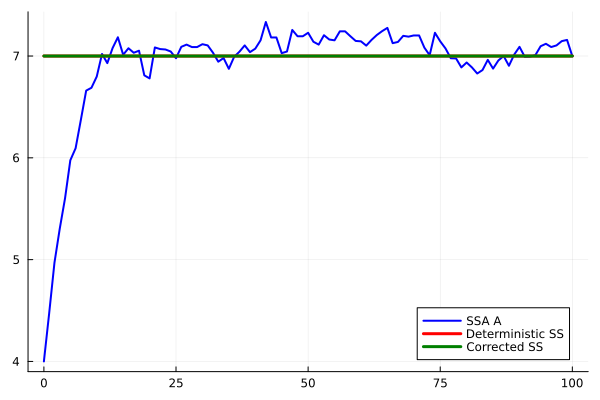

In [113]:
plot(timePoints, [array[1] for array in SSAmeans], color="blue", lw=2, label="SSA A")
plot!([0, tEnd], [SS[1], SS[1]], color="red", lw=3, label = "Deterministic SS")
plot!([0, tEnd], [realizedSS[1], realizedSS[1]], color="green", lw=3, label="Corrected SS")

## Simple Conservation Law Example ##

In [26]:
rn = @reaction_network begin
    @species A(t) B(t)
    @parameters k1 k2
    k1, A+B-->B
    k2, 0-->A
end
display(rn)
display(convert(ODESystem,rn))
# ics = [4, 3, 1]
# params = [0.2, 0.5]
# volume = 2.5; tEnd = 80; numSteps = 101; numTrajs = 10000;
# conservationEqs = [rn.species[1]~(ics[1]+ics[3])/volume-rn.species[3], rn.species[2]~(ics[2]+ics[3])/volume-rn.species[3]]
# display(conservationEqs)

ics = [5, 1]
volume = 1
params = [0.2, 1]
tEnd = 80; numSteps = 101; numTrajs = 10000;
timePoints, SSAmeans, SS, realizedSS = EMRE(rn, ics, params, volume, tEnd, numSteps, numTrajs);


Model ##ReactionSystem#255
States (2):
  A(t)
  B(t)
Parameters (2):
  k1
  k2

Model ##ReactionSystem#255 with 2 equations
States (2):
  A(t)
  B(t)
Parameters (2):
  k1
  k2

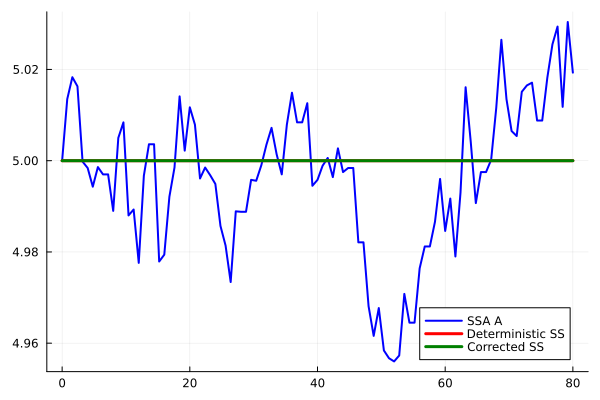

In [25]:
plot(timePoints, [array[1] for array in SSAmeans], color="blue", lw=2, label="SSA A")
plot!([0, tEnd], [SS[1], SS[1]], color="red", lw=3, label = "Deterministic SS")
plot!([0, tEnd], [realizedSS[1], realizedSS[1]], color="green", lw=3, label="Corrected SS")


In [66]:


rn = @reaction_network begin
    @species A(t) B(t) C(t)
    @parameters k1 k2
    (k1, k2), A+B<-->C
end
display(rn)
display(convert(ODESystem,rn))
ics = [4, 3, 1]
params = [0.2, 0.5]
volume = 2.5; tEnd = 80; numSteps = 101; numTrajs = 10000;
conservationEqs = [rn.species[1]~(ics[1]+ics[3])/volume-rn.species[3], rn.species[2]~(ics[2]+ics[3])/volume-rn.species[3]]
display(conservationEqs)



Model ##ReactionSystem#427
States (3):
  A(t)
  B(t)
  C(t)
Parameters (2):
  k1
  k2

Model ##ReactionSystem#427 with 3 equations
States (3):
  A(t)
  B(t)
  C(t)
Parameters (2):
  k1
  k2

2-element Vector{Equation}:
 A(t) ~ 2.0 - C(t)
 B(t) ~ 1.6 - C(t)

In [70]:
timePoints, SSAmeans, SS, realizedSS = EMRE(rn, ics, params, volume, tEnd, numSteps, numTrajs);

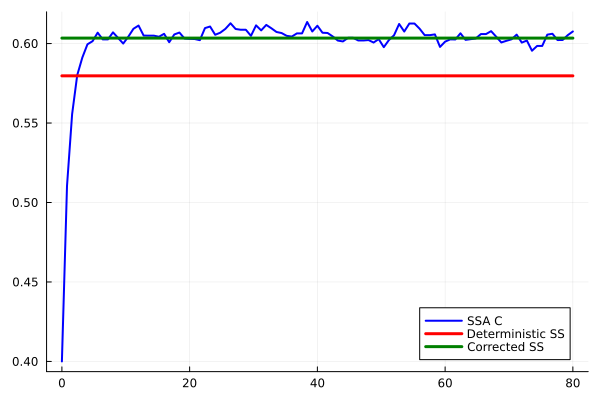

In [71]:
plot(timePoints, [array[3] for array in SSAmeans], color="blue", lw=2, label="SSA C")
plot!([0, tEnd], [SS[3], SS[3]], color="red", lw=3, label = "Deterministic SS")
plot!([0, tEnd], [realizedSS[3], realizedSS[3]], color="green", lw=3, label="Corrected SS")

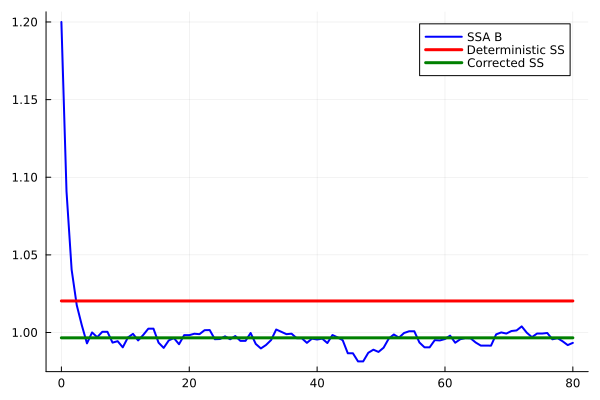

In [63]:
plot(timePoints, [array[2] for array in SSAmeans], color="blue", lw=2, label="SSA B")
plot!([0, tEnd], [SS[2], SS[2]], color="red", lw=3, label = "Deterministic SS")
plot!([0, tEnd], [realizedSS[2], realizedSS[2]], color="green", lw=3, label="Corrected SS")

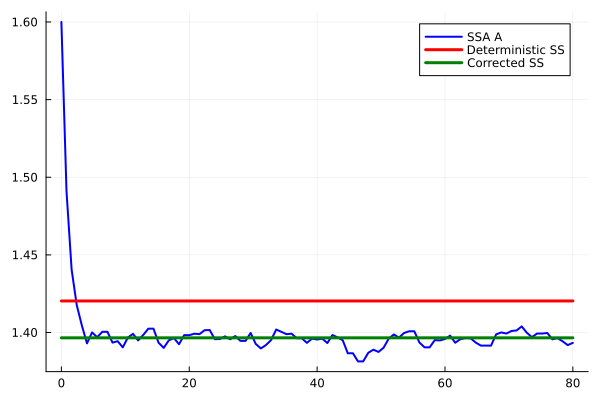

In [64]:
plot(timePoints, [array[1] for array in SSAmeans], color="blue", lw=2, label="SSA A")
plot!([0, tEnd], [SS[1], SS[1]], color="red", lw=3, label = "Deterministic SS")
plot!([0, tEnd], [realizedSS[1], realizedSS[1]], color="green", lw=3, label="Corrected SS")

## Example A from paper ##

In [68]:
X1_0 = 2; X2_0 = 40; ## define ics for each species
k1Param = 1000; k2Param = 100; k3Param = 10; ## define parameter values for all rates

tEnd = 10; ## run time
numSteps = 101; ## number of points to save SSA at
numTrajs = 1000; ## how many trajectories o use for SSA

ics = [X1_0, X2_0]; ## initial conditions for species in the order they are defined in the ReactionSystem
params = [k1Param, k2Param, k3Param]; ## parameter values for rates in the order they are defined in the ReactionSystem
volume = 1.2; ## volume of the system

rn = @reaction_network begin ## reaction network
    @species X1(t) X2(t)
    @parameters k1 k2 k3
    k1, X1 <-- 0
    k2, X1+X1 --> X2
    k3, X1 --> 0
    k3, X2 --> 0
end;
display(rn)
display(convert(ODESystem, rn, combinatoric_ratelaws=false))

Model ##ReactionSystem#257
States (2):
  X1(t)
  X2(t)
Parameters (3):
  k1
  k2
  k3

Model ##ReactionSystem#257 with 2 equations
States (2):
  X1(t)
  X2(t)
Parameters (3):
  k1
  k2
  k3

In [69]:
timePoints, SSAmeans, SS, realizedSS = EMRE(rn, ics, params, volume, tEnd, numSteps, numTrajs);

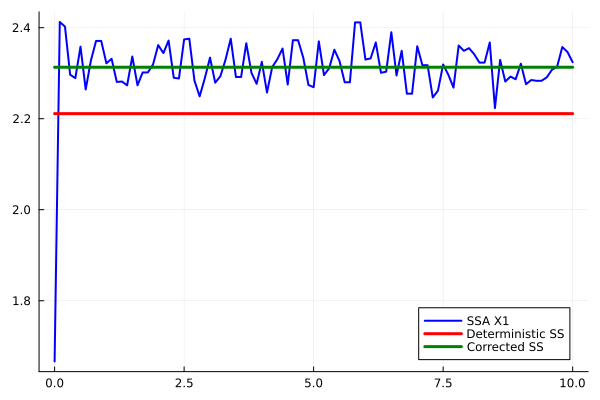

In [70]:
## plotting species 1

plot(timePoints, [array[1] for array in SSAmeans], color="blue", lw=2, label="SSA X1")
plot!([0, tEnd], [SS[1], SS[1]], color="red", lw=3, label = "Deterministic SS")
plot!([0, tEnd], [realizedSS[1], realizedSS[1]], color="green", lw=3, label="Corrected SS")#, ylim=(2,3))

Example B from paper

In [134]:
X1_0 = 0; X2_0 = 0; X3_0 = 0; ## define ics for each species
k1Param = 500; k2Param = 40; k3Param = 50; ## define parameter values for all rates

tEnd = 10; ## run time
numSteps = 101; ## number of points to save SSA at
numTrajs = 1000; ## how many trajectories o use for SSA

ics = [X1_0, X2_0, X3_0]; ## initial conditions for species in the order they are defined in the ReactionSystem
params = [k1Param, k2Param, k3Param]; ## parameter values for rates in the order they are defined in the ReactionSystem
volume = 3; ## volume of the system

rn = @reaction_network begin ## reaction network
    @species X1(t) X2(t) X3(t)
    @parameters k1 k2 k3
    k1, 0 --> 2*X1
    k1, 0 --> 2*X2 
    k2, X1+X2 --> X3
    k3, X1 --> 0
    k3, X2 --> 0
    k3, X3 --> 0
end;

In [135]:
timePoints, SSAmeans, SS, realizedSS = EMRE(rn, ics, params, volume, tEnd, numSteps, numTrajs);

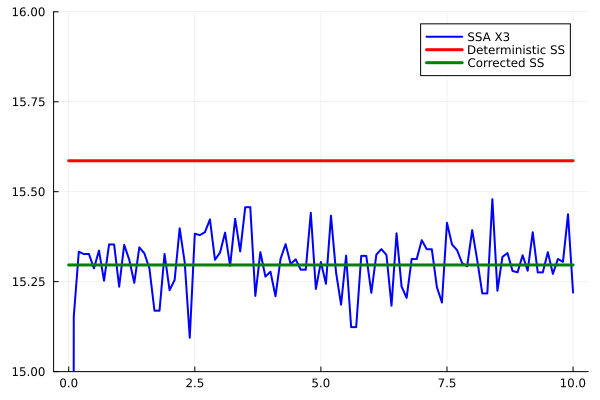

In [136]:
## plotting species 1

plot(timePoints, [array[3] for array in SSAmeans], color="blue", lw=2, label="SSA X3")
plot!([0, tEnd], [SS[3], SS[3]], color="red", lw=3, label = "Deterministic SS")
plot!([0, tEnd], [realizedSS[3], realizedSS[3]], color="green", lw=3, label="Corrected SS",ylim=(15,16))

In [ ]:
# function buildSMatrix(rn::ReactionSystem)

#     SMat = zeros(length(rn.species), length(rn.rxs));
    
#     i = 1;
#     for reaction in rn.rxs
#         for speciesChange in reaction.netstoich
#             speciesIdx = findfirst(x->isequal(x,speciesChange[1]), rn.species);
#             SMat[speciesIdx, i] = speciesChange[2]
#         end;
#         i += 1;
#     end;
    
#     return SMat;
# end;

In [ ]:
# function solveRateEqs(rn::ReactionSystem, ics, params, reducedSpecies = nothing, reducedSystem = nothing)

#     if reducedSpecies != nothing && reducedSystem != nothing
#         println("not set up yet")
#         sol = 1; ## will need to use conservation laws to get removed species, but use full system for the Lyapunov stuff
#     else
#         deSystem = convert(ODESystem, rn, combinatoric_ratelaws=false);
#         ssProb = SteadyStateProblem(deSystem, [rn.species[i] => ics[i] for i in 1:length(rn.species)], [rn.ps[i] => params[i] for i in 1:length(rn.ps)]);

#         sol = solve(ssProb, SSRootfind())
#     end;
#     return sol;
# end;

In [ ]:
# function buildFMatrix(rn::ReactionSystem, steadyStates, reducedSpecies = nothing, reducedSystem = nothing)

#     if reducedSpecies != nothing && reducedSystem != nothing
#         println("not set up yet")
#         fMat = zeros(length(rn.rxs), length(rn.rxs))

#     else
#         fMat = zeros(length(rn.rxs),length(rn.rxs))

#         i = 1
#         for reaction in rn.rxs
#             rateIdx = findfirst(x->isequal(x,reaction.rate), rn.ps)
            
#             if length(reaction.substrates) == 2 
#                 species1idx = findfirst(x->isequal(x,reaction.substrates[1]), rn.species)
#                 species2idx = findfirst(x->isequal(x,reaction.substrates[2]), rn.species)
#                 fMat[i,i] = params[rateIdx]*steadyStates[species1Idx]*steadyStates[species2Idx]
                
#             elseif length(reaction.substrates) == 0
#                 fMat[i,i] = params[rateIdx]

#             elseif (length(reaction.substrates) == 1) && (reaction.substoich[1] == 2)
#                 speciesIdx = findfirst(x->isequal(x,reaction.substrates[1]), rn.species)
#                 fMat[i,i] = params[rateIdx]*(steadyStates[speciesIdx])^2

#             elseif length(reaction.substrates) == 1
#                 speciesIdx = findfirst(x->isequal(x, reaction.substrates[1]), rn.species)
#                 fMat[i,i] = params[rateIdx]*steadyStates[speciesIdx]
#             end;
            
#             i += 1
#         end;
#     end;

#     return fMat;
# end;

In [ ]:
# function buildDMatrix(SMat, FMat)
#     DMatrix = SMat*FMat*transpose(SMat);
#     return DMatrix;
# end;

In [ ]:
# function createLyupanovDEs(rn::ReactionSystem, ics, params, reducedSpecies = nothing, reducedSystem = nothing)

#     if reducedSpecies != nothing && reducedSystem != nothing
#         println("not set up yet")
#         DEs = 1
#     else
#         sys = convert(ODESystem, rn, combinatoric_ratelaws=false)
#         jacMat = calculate_jacobian(sys)

#         steadyStates = solveRateEqs(rn, ics, params)

#         subDict = Dict([])
#         for species in rn.species
#             speciesIdx = findfirst(x->isequal(x, species), rn.species)
#             subDict[species] = steadyStates[speciesIdx]
#         end
#         for param in rn.ps
#             paramIdx = findfirst(x->isequal(x,param), rn.ps)
#             subDict[param] = params[paramIdx]
#         end

#         SMat = buildSMatrix(rn);
#         FMat = buildFMatrix(rn, steadyStates)
#         DMat = buildDMatrix(SMat, FMat)
#         jacMat = substitute(jacMat, subDict)

#         CMat = [@variables for i in 1:5]
#         display(CMat)

#         DEs = jacMat*CMat + CMat*transpose(jacMat)+DMat;
#     end;
#     return DEs;
# end;

In [ ]:
# function solveLyupanov(rn, ics, params, reducedSpecies = nothing, reducedSystem = nothing)

#     if reducedSpecies != nothing && reducedSystem != nothing
#         println("not set up yet")

#     else

#         DEs = createLyupanovDEs(rn, ics, params)

#         eqs = []
#         for i in 1:length(rn.species)
#             for j in 1:length(rn.species)
#                 push!(eqs, DEs[i,j])
#             end;
#         end;

#         @named sys = ODESystem(eqs)

#     end;

# end;